In [2]:
import sys
sys.path.insert(0, '../')

import flammkuchen as fl
import tensorflow as tf
from utils.params import Params
from neural_networks.src.dataloader import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import efficientnet.tfkeras as efn

In [3]:
#### Change 'PATH_GA_O2' to the path where your trained GA model is located ####
PATH_GA_O2 = "../neural_networks/GeneticAlgorithm/Results_GA/GA_20211115-105541_objective2/best_models_per_generation/gen17_Fitness2.4656.hdf5"

PATH_PARAMS = "../neural_networks/params.json"

In [4]:
model_ga_o2 = tf.keras.models.load_model(PATH_GA_O2, custom_objects={'leaky_relu': tf.nn.leaky_relu, 'relu6': tf.nn.relu6})

In [5]:
# load parameter
params = Params(PATH_PARAMS)
params.signal_type = "NSA"

# load test data
data_loader = DataLoader(params=params, nb_classes=4)
X_test, Y_test = data_loader.get_test_data()


Currently loading data: P6_1


  0%|          | 0/1882 [00:00<?, ?it/s]


Currently loading data: P6_2


  0%|          | 0/1790 [00:00<?, ?it/s]


Currently loading data: P6_3


  0%|          | 0/1805 [00:00<?, ?it/s]

In [8]:
def get_occlusions(model, X_test, Y_test, patch_sizes=[8], stride=2):  
    image_x_dim = X_test[0].shape[0] 
    image_y_dim = X_test[0].shape[1] 
    
    # calculate occlusions
    all_result_images = []
    all_counter_images = []
    for patch_size in patch_sizes:
        # create empty result_image to fill it with the predictions at the occluded positions
        result_image = np.zeros((4, image_x_dim,  image_y_dim))
        counter_image = np.zeros((4, image_x_dim,  image_y_dim))
        
        for x in range(0,  image_x_dim-patch_size+1, stride):
            for y in range(0,  image_y_dim-patch_size+1, stride):
                images = np.copy(X_test)
                images[..., x:x+patch_size, y:y+patch_size] = -1 # occlud area through setting the values there to -1
                
                # predict the occluded image
                pred = model.predict(images[..., None])
                     
                for z in range(len(images)):
                    for j in range(4):
                        if Y_test[z, j] == 1:
                            result_image[j, x:x+patch_size, y:y+patch_size] += pred[z, j]
                            counter_image[j, x:x+patch_size, y:y+patch_size] += 1
        all_result_images.append(result_image)
        all_counter_images.append(counter_image)
        
    for r in range(len(all_result_images)):
        for s in range(4):
            all_result_images[r][s] /= all_counter_images[r][s]
        
    return all_result_images

In [ ]:
occlusions_ga_o2 = get_occlusions(model_ga_o2, X_test, Y_test, [16], 4)

## Create dict with Occlusion results for each airway symptom and save it

In [32]:
d = dict()

patch = occlusions_ga_o2[0]
d = dict(d, cough_occlusions=patch[0],
         dryswallow_occlusions=patch[1],
         throatclear_occlusions=patch[2],
         noevent_occlusions=patch[3],)

fl.save("results_occlusion_experiments.vfp", d)

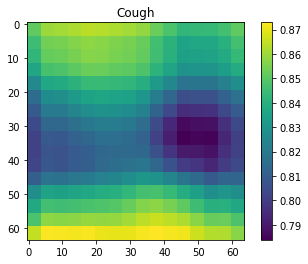

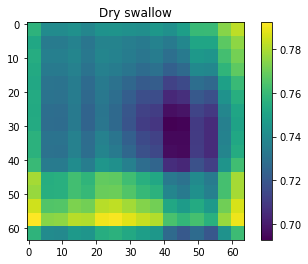

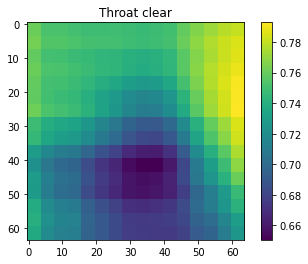

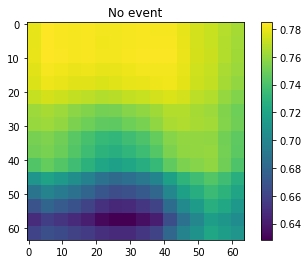

In [31]:
titles = ['Cough', 'Dry swallow', 'Throat clear', 'No event']
# plot occlusions from ga model
for patch in occlusions_ga_o2:
    for idx, occlusion_class in enumerate(patch):
        plt.imshow(occlusion_class)
        plt.colorbar()
        plt.title(titles[idx])
        plt.show()